In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables

Base.prepare(engine, reflect=True)



C:\Users\UT4Me\AppData\Local\Temp\ipykernel_20720\3284749242.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [12]:
# View all of the classes that automap found
for class_name in Base.classes.keys():
    print(class_name)

station
measurement


In [13]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [14]:
# Create our session (link) from Python to the DB

session = Session(bind=engine)


# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.
# Assuming 'Measurement' is your table class and it has a column named 'date'
most_recent_date = session.query(func.max(Measurement.date)).one()[0]

print(most_recent_date)


2017-08-23


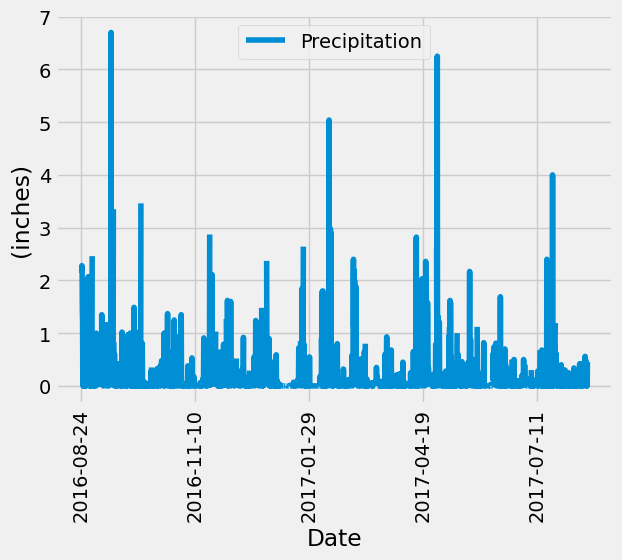

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.strptime(most_recent_date_str, "%Y-%m-%d")
# Calculate the date one year from the last date in data set.
one_year_back = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_back).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query_results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('(inches)')
plt.show()



In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics_df = df['Precipitation'].describe().to_frame('Precipitation')

summary_statistics_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()

total_stations

9

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.station).desc()
).all()

for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")






Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = most_active_stations[0][0] 

temperatures = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(
    Measurement.station == most_active_station_id
).one()

lowest_temp, highest_temp, average_temp = temperatures

temperatures

(54.0, 85.0, 71.66378066378067)

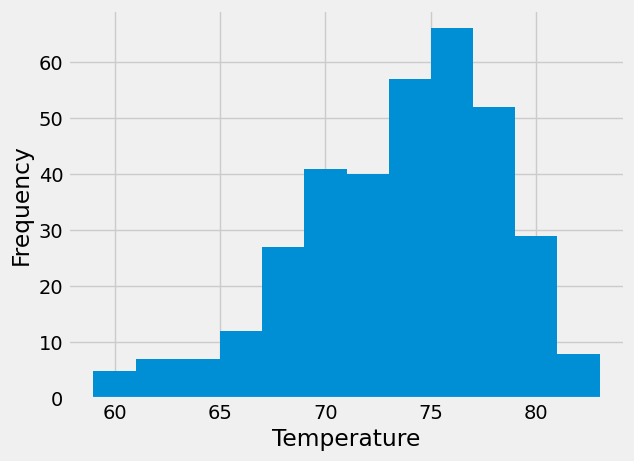

In [35]:
# Using the most active station id

start_date = most_recent_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= start_date).\
    all()

temperatures = [temp[0] for temp in temperature_results]

plt.hist(temperatures, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [36]:
# Close Session
session.close()